This is the notebook of Milestone 2 of team _Ada And the Lovelaces_. The outline of the notebook is as followed:
1. Data Pre-Processing: we add the features of interest to the existing datasets
2. Exploratory Data Analysis: based on the datasets obtained, we run some first basic analysis and visualizations


In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import urllib.parse as urlparse
from collections import defaultdict

from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import re
import os
import networkx as nx

# Data pre-processing

## Computing the location of the links in the HTML pages

In this part, we compute the location of every link in a given HTML page. The location is added to the _links_ table.

Let's start by extracting the links, and creating the new columns we wish to add, with 0 as the initialization value:

In [2]:
# Extract list of links as DataFrame to store frequency

df_links = pd.read_csv('./data/wikispeedia_paths-and-graph/links.tsv',
                       sep='\t',
                       names=['linkSource_URL', 'linkTarget_URL'],
                       comment='#')

# Storing the x and y position of the unique link on the page
df_links['xpos'] =  pd.Series(np.zeros((len(df_links)),dtype=int))
df_links['ypos'] =  pd.Series(np.zeros((len(df_links)),dtype=int))

Now, the HTML driver is created. We need to define arbitrary parameters. We consider a full screen display at 1900*900, rendered in Google Chrome. 




_Note that if we were to change the resolution, the data would change but the ordering of the links locations on the y axis would remain unchanged. The results of the analysis would not change._

In [3]:
op = Options()
op.add_argument('headless')


# Most common window size for desktop, 
# full-screen minus 130 at top for browser control, minus 50 at bottom for windows taskbar. 
# Since the game was played, on desktop, we choose this (ADD EXPLANATORY SCREENSHOT)

op.add_argument("window-size=1920,900") 

driver = webdriver.Chrome(options=op)

Now that the driver is configured, let's compute the locations of all links in the articles

In [4]:
source_path = './data/wpcd/wp/f/France.htm'

user_cwd = os.getcwd().replace('\\','/')

url = 'file://'+user_cwd+source_path
driver.get(url)

elem = driver.find_elements(By.TAG_NAME, "a")
for e in elem:
    
    if e.text != '':
        print('link name', e.text, 'link pos', e.location)

link name 2007 Schools Wikipedia Selection link pos {'x': 19, 'y': 52}
link name Countries link pos {'x': 294, 'y': 52}
link name European Countries link pos {'x': 351, 'y': 52}
link name Paris link pos {'x': 1724, 'y': 417}
link name French link pos {'x': 1724, 'y': 459}
link name Government link pos {'x': 1588, 'y': 483}
link name Accession to EU link pos {'x': 1604, 'y': 621}
link name Currency link pos {'x': 1626, 'y': 1049}
link name Euro link pos {'x': 1724, 'y': 1054}
link name Time zone link pos {'x': 1623, 'y': 1116}
link name European Union link pos {'x': 1748, 'y': 1577}
link name French link pos {'x': 68, 'y': 75}
link name French link pos {'x': 361, 'y': 75}
link name country link pos {'x': 688, 'y': 75}
link name Mediterranean Sea link pos {'x': 299, 'y': 94}
link name English Channel link pos {'x': 445, 'y': 94}
link name North Sea link pos {'x': 587, 'y': 94}
link name Rhine link pos {'x': 726, 'y': 94}
link name Atlantic Ocean link pos {'x': 798, 'y': 94}
link name Bel

## Computing clicks, impressions and CTR

This is done at two different granularities:
- Per source: we compute the clicks, impressions and CTR for each outgoing links of a given article
- Aggregated: we compute the total number of clicks, impressions and CTR for the articles no matter the origin of the user's click

### Fine grained dataset: per source article
Here, the goal is to extend the _links_ table by adding for each pair _(origin article, destination article)_, columns counting the number of clicks associated, the number of impressions, and the CTR.

In [5]:
# Helper functions

def title_parse(title):
    """
    Parse URL encoded to readable characters
    """

    title = urlparse.unquote(title).casefold()
    return title



def url_encode(title):
    """
    URL encode target links
    """

    title = urlparse.quote(title)
    return title


We start by retrieving the players's data: they are in the paths_finished and paths_unfinished datasets. We first focus on the finished paths:

In [6]:
df_user_finished = pd.read_csv('./data/wikispeedia_paths-and-graph/paths_finished.tsv',
                      sep='\t',
                      names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'],
                      comment='#')

# It was noticed that users clicked on links in the footer (Terms & Conditions + Disclaimer) 
# that are not articles per-say. We decided to remove all paths containing these links as it is not in the spirit of the game
## "wikipedia_text_of_the_gnu_free_documentation_license" is not an article!
problematic_keywords = ['Wikipedia_Text_of_the_GNU_Free_Documentation_License']
df_user_finished = df_user_finished[~df_user_finished.path.str.contains('|'.join(problematic_keywords))]

# Drop unused columns for objectives and transform to list of paths
df_user_finished = df_user_finished.drop(['hashedIpAddress', 'timestamp', 'durationInSec', 'rating'], axis=1).squeeze()


We now enrich our series_paths dataframe with the unfinished paths

In [7]:
df_user_unfinished = pd.read_csv('./data/wikispeedia_paths-and-graph/paths_unfinished.tsv',
                      sep='\t',
                      names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"],
                      comment='#')

# It was noticed that users clicked on links in the footer (Terms & Conditions + Disclaimer) 
# that are not articles per-say. We decided to remove all paths containing these links as it is not in the spirit of the game
## "wikipedia_text_of_the_gnu_free_documentation_license" is not an article!
problematic_keywords = ['Wikipedia_Text_of_the_GNU_Free_Documentation_License']

df_user_unfinished = df_user_unfinished[~df_user_unfinished.path.str.contains('|'.join(problematic_keywords))]

df_user_unfinished = df_user_unfinished.drop(['hashedIpAddress', 'timestamp', 'durationInSec', 'target', 'type'], axis=1).squeeze()

In [8]:
df_user = df_user_finished.append(df_user_unfinished)

# Decode URL encoding for paths, case fold
series_paths = df_user.map(title_parse)

# Transform paths to list of inputs (article names or <)
series_paths = series_paths.str.split(';')

C:\Users\nilsh\AppData\Local\Temp\ipykernel_15912\3916051144.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_user = df_user_finished.append(df_user_unfinished)


We add the new columns of interest in the df_links dataframe, and initialize them:

In [9]:

# Definitions
# Source Links are the link of the page on which a link is shown
# Target Links are the outgoing link on which the user lands

# Filenames are single encoded (ie C++.htm is encoded at C%2B%2B.htm)
# Outgoing names in the HTML source are DOUBLE encoded (ie C++.htm is <a href="../../wp/c/C%252B%252B.htm">
# Therefore, we add a helper column for linkTarget_2URL storing the DOUBLE URL ENCODED string
df_links['linkTarget_2URL'] = df_links['linkTarget_URL'].map(url_encode)

# Decode URL encoding for paths, case fold (from URL encoding to readable)
df_links['linkSource'] = df_links['linkSource_URL'].map(title_parse)
df_links['linkTarget'] = df_links['linkTarget_URL'].map(title_parse)

# Merge columns in tuple for easy lookup (unique key), format source;target
df_links['linkPair'] = df_links['linkSource'] + ';' + df_links['linkTarget']

# Number of impressions will be counted in column 'impressions' for each pair
df_links['impressions'] = pd.Series(np.zeros((len(df_links)),dtype=int))

# Number of clicks will be counted in column 'clicks' for each pair
df_links['clicks'] = pd.Series(np.zeros((len(df_links)),dtype=int))



The next block of code serves for optimization.

In [10]:
# Optimization step, preprocessing indices to use numpy arrays for faster access
# For all articles names, create a list of rows in the df_links that have this article as source
source_map = defaultdict(list)
for link_id, source in enumerate(df_links['linkSource']):
  source_map[source].append(link_id)

# Create a reverse dictionary to index nparray
# list[int]=string to dict[string]=int
my_map = dict(df_links['linkPair'])
pair_map = dict((v, k) for k, v in my_map.items())

The computation of the number of clicks and impressions:

In [11]:
np_links = df_links.to_numpy()
IMPRESSIONS_COLUMN_ID = df_links.columns.get_loc('impressions')
clicks_COLUMN_ID = df_links.columns.get_loc('clicks')
XPOS_COLUMN_ID = df_links.columns.get_loc('xpos')
YPOS_COLUMN_ID = df_links.columns.get_loc('ypos')

# For each path, count forward link clicks
for path in series_paths:
    # Initialise stack with first link
    foo = list()
    foo.append(path[0])
    # Iterate over every step of user's path
    for element in path[1:]:
        if element != '<':

            # If next element in path is not a return character, store information and analyze
            ## Source node is the current top of stack
            source_node = foo[-1]

            ## Add next link in list to top of stack
            foo.append(element)

            ## New top of stack is target
            target_node = foo[-1]

            # Create key for pair identification
            search_value = source_node + ';' + target_node

            # Some issues were discovered with the dataset and encoding: some link pairs are missing
            ### ie 'finland;åland' is not in our dataset, BUT the link 'åland' out of finland EXISTS on the source article and was used by the user
            # It was not listed as an outgoing link in the dataset
            try:
                pair = pair_map[search_value]
                
            except Exception as e:
                # Catch when pair was not listed in dataset, don't add impression and disregard
                print('Invalid pair:',e) # For debug and understanding dataset
                break

            ## Count one impression for all pairs with source_node as source (source_node;*)
            source = source_map[source_node]
            np_links[source,IMPRESSIONS_COLUMN_ID] += 1

            ## Add one click-through for the pair (source_node;target_node)
            np_links[pair,clicks_COLUMN_ID] += 1

        else:
            # If return character is read, pop top of stack and don't store any info
            foo.pop()

Invalid pair: 'finland;åland'
Invalid pair: 'finland;åland'
Invalid pair: 'republic_of_ireland;éire'
Invalid pair: 'republic_of_ireland;éire'
Invalid pair: 'claude_monet;édouard_manet'
Invalid pair: 'republic_of_ireland;éire'
Invalid pair: 'claude_monet;édouard_manet'
Invalid pair: 'republic_of_ireland;éire'
Invalid pair: 'finland;åland'
Invalid pair: 'finland;åland'
Invalid pair: 'ireland;éire'
Invalid pair: 'republic_of_ireland;éire'
Invalid pair: 'ireland;éire'
Invalid pair: 'impressionism;édouard_manet'
Invalid pair: 'claude_monet;édouard_manet'
Invalid pair: 'francisco_goya;édouard_manet'
Invalid pair: 'republic_of_ireland;éire'
Invalid pair: 'ireland;éire'
Invalid pair: 'ireland;éire'
Invalid pair: 'republic_of_ireland;éire'
Invalid pair: 'claude_monet;édouard_manet'
Invalid pair: 'republic_of_ireland;éire'


Let's put back the values obtained in np_links in the df_links dataframe, since dataframes are easier to handle than series

In [12]:
columns = ['linkSource_URL', 'linkTarget_URL', 'xpos', 'ypos', 'linkTarget_2URL', 'linkSource', 'linkTarget', 'linkPair', 'impressions', 'clicks']
to_dict_values = {}


for i in range(len(columns)):

    col = columns[i]
    to_dict_values[col] = [np_links[k][i] for k in range(len(np_links))]

df_links = pd.DataFrame(to_dict_values)


Now, we can finally compute the CTR

In [13]:
df_links['CTR'] = df_links.clicks / df_links.impressions

Saving the obtained dataset

In [14]:
df_links.to_csv('./output/output_links.csv',encoding='utf-8-sig')

### Coarse-grained dataset: Aggregated view over all website
Here, the goal is to extend the _articles_ table by adding columns representing the total number of clicks, the number of impressions and the CTR. Except for the CTR, we can simply sum the obtained numbers in the finer granularity.

Let's extract the articles data by aggregating the df_links dataframe

In [15]:
articles = df_links[["linkTarget", "impressions", "clicks"]].groupby(by=["linkTarget"]).sum()
articles["CTR"] = articles["clicks"]/articles["impressions"]

Let's save the result

In [16]:
articles.to_csv('./output/output_articles.csv',encoding='utf-8-sig')

# Exploratory Data Analysis

## Understanding the Wikispeedia network

To have a better understanding of the structure of the links, we wish to create a graph of the network.

In [19]:
G = nx.DiGraph()
G = nx.from_pandas_edgelist(df_links, source='linkSource', target='linkTarget')

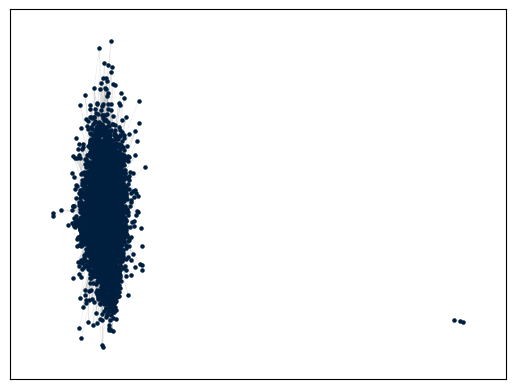

In [20]:
nx.draw_networkx(G, with_labels=False, node_size=5, node_color="#001f3f", width=0.1, edge_color="#AAAAAA")

Interestingly, we distinguish two strongly separate connected components. We can verify that easily:

In [21]:
print("There are " + str(nx.number_connected_components(G)) + "  connected components in the graph.")

There are 2  connected components in the graph.


In [22]:
print("Unconnected components: "+ str(list(nx.connected_components(G))[1]))

Unconnected components: {'directdebit', 'sponsorship_directdebit', 'friend_directdebit'}


This is linked to pages for donations, these are not Wikipedia articles and will be removed.

## Data Distribution

Let's explore the dataset we have obtained.

In [23]:
print('There exist', len(df_links), 'links in total.','\n')
print('The unique articles are:', df_links.linkSource.nunique())
df_links['linkSource'].value_counts()

There exist 119882 links in total. 

The unique articles are: 4587


united_states                     294
driving_on_the_left_or_right      255
list_of_countries                 244
list_of_circulating_currencies    236
list_of_sovereign_states          216
                                 ... 
lighting_designer                   1
soil_structure                      1
pro_milone                          1
soil_profile                        1
human_dignity                       1
Name: linkSource, Length: 4587, dtype: int64

Text(0.5, 0, 'Article')

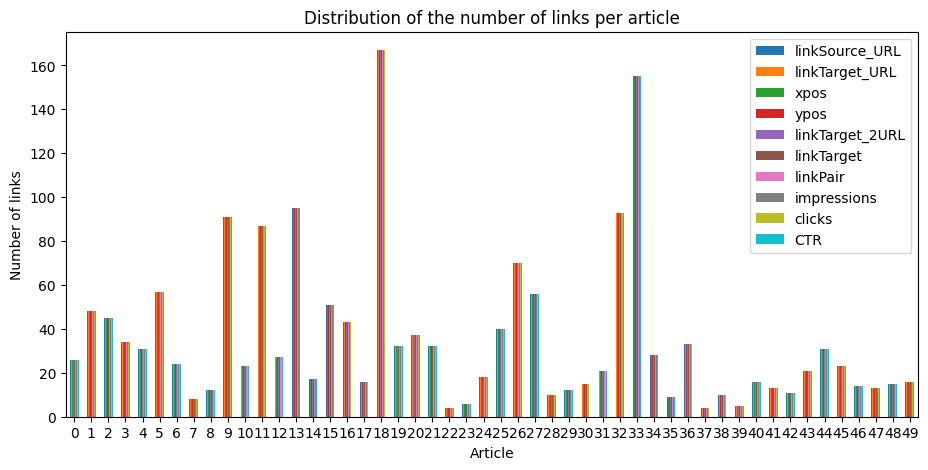

In [24]:
group_by_links = df_links.groupby(by="linkSource").count().reset_index()[:50]

pl = group_by_links.plot(kind='bar', figsize=[11,5], rot=0)
pl.set_title('Distribution of the number of links per article')
pl.set_ylabel('Number of links')
pl.set_xlabel('Article')

We can see that the number of links per article does not follow a uniform distribution. There are articles that have more than 160 links while others have less than 20.

<AxesSubplot: title={'center': 'Number of clicks'}, ylabel='Frequency'>

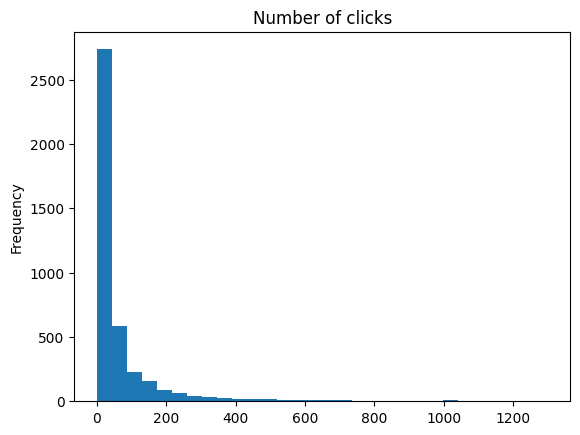

In [31]:
articles["clicks"].plot.hist(bins=30, range=[0,1300], title="Number of clicks")

Let's rank the top 10 most clicks articles:

In [38]:
articles.sort_values(by=['clicks'], ascending=False).head(10)

,impressions,clicks,CTR
linkTarget,,,
united_states,154518,12376,0.080094
europe,133170,5565,0.041789
united_kingdom,123566,5303,0.042916
england,65232,4413,0.067651
earth,61419,4172,0.067927
africa,68411,3490,0.051015
world_war_ii,102791,2893,0.028144
north_america,70097,2546,0.036321
animal,42468,2426,0.057125


Now focusing on impressions:

<AxesSubplot: title={'center': 'Number of impressions'}, ylabel='Frequency'>

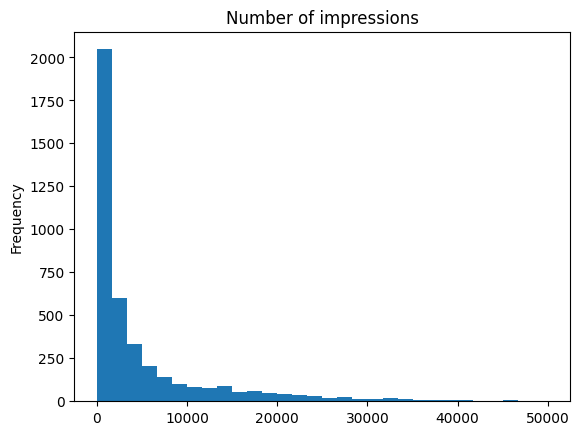

In [36]:
articles["impressions"].plot.hist(bins=30, title="Number of impressions", range=[0,50000])

Let's rank the top 10 articles with highest impressions

In [39]:
articles.sort_values(by=['impressions'], ascending=False).head(10)

,impressions,clicks,CTR
linkTarget,,,
united_states,154518,12376,0.080094
europe,133170,5565,0.041789
france,132404,2225,0.016805
united_kingdom,123566,5303,0.042916
germany,105443,2167,0.020551
world_war_ii,102791,2893,0.028144
latin,101089,959,0.009487
india,97125,1750,0.018018
spain,93086,773,0.008304


The finaly analysis is made on CTR:

<AxesSubplot: title={'center': 'Distribution of CTR'}, ylabel='Frequency'>

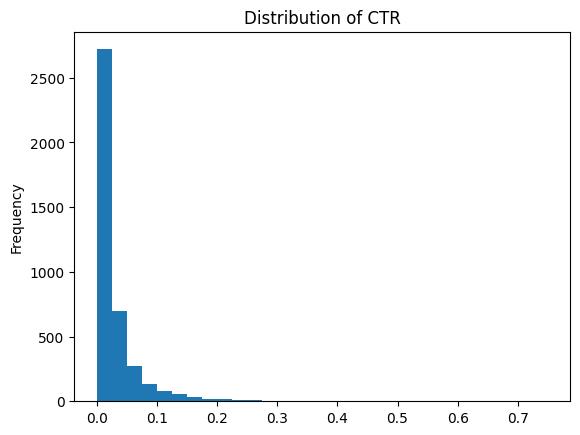

In [37]:
articles["CTR"].plot.hist(bins=30, title="Distribution of CTR", range=[0,0.75])

With the top 10 CTR ranking:

In [40]:
articles.sort_values(by=['CTR'], ascending=False).head(10)

,impressions,clicks,CTR
linkTarget,,,
list_of_european_countries,4,3,0.750000
exploration_of_mars,23,15,0.652174
wta_tour_championships,9,5,0.555556
the_lion_king,501,277,0.552894
gray_reef_shark,26,14,0.538462
ffestiniog_railway,2,1,0.500000
shenzhou_spacecraft,23,11,0.478261
battle_of_bicocca,13,6,0.461538
irish_theatre,14,6,0.428571


This last ranking might not be very useful since some articles have very low impressions, meaning we don't have enough data. The obtained CTR seem very high.

In [34]:
print("The average number of clicks is " + str(articles.clicks.mean()))
print("The average number of impressions is " + str(articles.impressions.mean()))
print("The average CTR is " + str(articles.CTR.mean()))

The average number of clicks is 88.35985489721887
The average number of impressions is 5661.276420798065
The average CTR is 0.030189658307541396


## Sanity Check

Let's now check how clean how dataset is, and if we have missing data.